# Daily NY Subway Entries vs Citi Bike Trips between March and May 2021

## Importing MTA Data from SQL DB

In [1]:
import pandas as pd
import datetime as dt
import sqlite3

In [2]:
con = sqlite3.connect("mta_data_2021.db")

query = '''
SELECT *
from mta_data;
'''

# Load the data into a DataFrame
df = pd.read_sql_query(query, con)

con.close()

## Data cleaning - remove duplicate entries

In [3]:
mta = df.copy()

In [4]:
# Merge DATE and TIME columns and convert to datetime data type
mta["DATE_TIME"] = pd.to_datetime(mta.DATE + " " + mta.TIME)
mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2591002 entries, 0 to 2591001
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   LINENAME   object        
 5   DIVISION   object        
 6   DATE       object        
 7   TIME       object        
 8   DESC       object        
 9   ENTRIES    int64         
 10  EXITS      float64       
 11  DATE_TIME  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 237.2+ MB


In [5]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(mta.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
230413,B024,R211,00-05-00,KINGS HWY,2021-05-02 08:00:00,2
230417,B024,R211,00-05-00,KINGS HWY,2021-05-03 00:00:00,2
230415,B024,R211,00-05-00,KINGS HWY,2021-05-02 16:00:00,2
230414,B024,R211,00-05-00,KINGS HWY,2021-05-02 12:00:00,2
230412,B024,R211,00-05-00,KINGS HWY,2021-05-02 04:00:00,2


Since we are only taking the last reading of ENTRIES for each day, we should be okay to remove these duplicate records.

In [6]:
# Get rid of the duplicate entry, and sort by date
mta.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ignore_index=True)
mta.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [7]:
# Sanity Check again to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(mta.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-02-27 03:00:00,1
1727284,R128,R105,01-03-02,14 ST,2021-03-06 11:00:00,1
1727277,R128,R105,01-03-02,14 ST,2021-03-05 07:00:00,1
1727278,R128,R105,01-03-02,14 ST,2021-03-05 11:00:00,1
1727279,R128,R105,01-03-02,14 ST,2021-03-05 15:00:00,1


In [8]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
mta = mta.drop(["EXITS", "DESC"], axis=1, errors="ignore")

## Calculate daily entries

In [29]:
mta_daily = mta.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE']).ENTRIES.max().reset_index()
mta_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,02/27/2021,7537589
1,A002,R051,02-00-00,59 ST,NQR456W,02/28/2021,7537852
2,A002,R051,02-00-00,59 ST,NQR456W,03/01/2021,7538400
3,A002,R051,02-00-00,59 ST,NQR456W,03/02/2021,7538926
4,A002,R051,02-00-00,59 ST,NQR456W,03/03/2021,7539503


In [30]:
mta_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_daily
                                            .groupby(["C/A", "UNIT", "SCP", "STATION", 'LINENAME'])["DATE", "ENTRIES"]
                                            .apply(lambda grp: grp.shift(1)))
mta_daily

<ipython-input-30-1512c6fbd139>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_daily


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,02/27/2021,7537589,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,02/28/2021,7537852,02/27/2021,7537589.0
2,A002,R051,02-00-00,59 ST,NQR456W,03/01/2021,7538400,02/28/2021,7537852.0
3,A002,R051,02-00-00,59 ST,NQR456W,03/02/2021,7538926,03/01/2021,7538400.0
4,A002,R051,02-00-00,59 ST,NQR456W,03/03/2021,7539503,03/02/2021,7538926.0
...,...,...,...,...,...,...,...,...,...
433120,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/24/2021,5554,05/23/2021,5554.0
433121,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/25/2021,5554,05/24/2021,5554.0
433122,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/26/2021,5554,05/25/2021,5554.0
433123,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/27/2021,5554,05/26/2021,5554.0


In [31]:
# Drop the rows for the earliest date in the df
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [32]:
mta_daily

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,02/28/2021,7537852,02/27/2021,7537589.0
2,A002,R051,02-00-00,59 ST,NQR456W,03/01/2021,7538400,02/28/2021,7537852.0
3,A002,R051,02-00-00,59 ST,NQR456W,03/02/2021,7538926,03/01/2021,7538400.0
4,A002,R051,02-00-00,59 ST,NQR456W,03/03/2021,7539503,03/02/2021,7538926.0
5,A002,R051,02-00-00,59 ST,NQR456W,03/04/2021,7540040,03/03/2021,7539503.0
...,...,...,...,...,...,...,...,...,...
433120,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/24/2021,5554,05/23/2021,5554.0
433121,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/25/2021,5554,05/24/2021,5554.0
433122,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/26/2021,5554,05/25/2021,5554.0
433123,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,05/27/2021,5554,05/26/2021,5554.0


## Treating the readings that do not make sense

In [33]:
mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
388,A002,R051,02-03-02,59 ST,NQR456W,03/23/2021,668,03/22/2021,6641481.0
3550,A011,R080,01-03-00,57 ST-7 AV,NQRW,02/28/2021,885620334,02/27/2021,885620487.0
3551,A011,R080,01-03-00,57 ST-7 AV,NQRW,03/01/2021,885620231,02/28/2021,885620334.0
3552,A011,R080,01-03-00,57 ST-7 AV,NQRW,03/02/2021,885619997,03/01/2021,885620231.0
3553,A011,R080,01-03-00,57 ST-7 AV,NQRW,03/03/2021,885619808,03/02/2021,885619997.0


In [34]:
# Let's see how many stations have this problem
(mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A002   R051  02-03-02  59 ST               1
A011   R080  01-03-00  57 ST-7 AV         90
             01-03-03  57 ST-7 AV          1
             01-03-04  57 ST-7 AV          1
A013   R081  01-06-01  49 ST               1
                                          ..
R622   R123  00-00-00  FRANKLIN AV        81
R624   R124  00-00-02  KINGSTON AV         1
R730   R431  00-00-04  EASTCHSTER/DYRE    81
S101   R070  00-00-04  ST. GEORGE          1
TRAM2  R469  00-05-00  RIT-ROOSEVELT       1
Length: 221, dtype: int64

In [35]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed? let's reverse it back
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0 between two days?
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
mta_daily["DAILY_ENTRIES"] = mta_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [16]:
mta_daily.DAILY_ENTRIES.describe()

count    428076.000000
mean        435.749942
std        7075.351265
min           0.000000
25%          69.000000
50%         228.000000
75%         466.000000
max      983959.000000
Name: DAILY_ENTRIES, dtype: float64

In [36]:
# Group by station to have daily entries by station
station_daily = mta_daily.groupby(["STATION", "LINENAME", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()

,STATION,LINENAME,DATE,DAILY_ENTRIES
0,1 AV,L,02/28/2021,3639.0
1,1 AV,L,03/01/2021,6086.0
2,1 AV,L,03/02/2021,6254.0
3,1 AV,L,03/03/2021,6557.0
4,1 AV,L,03/04/2021,6506.0


In [37]:
# Sum by date
sum_daily = mta_daily.groupby("DATE")[['DAILY_ENTRIES']].sum().reset_index()
sum_daily.head()

,DATE,DAILY_ENTRIES
0,02/28/2021,745965.0
1,03/01/2021,1856714.0
2,03/02/2021,1669080.0
3,03/03/2021,1701992.0
4,03/04/2021,1814582.0


# Plotting Subway Ridership Trend

In [38]:
sum_daily['DATE'] = pd.to_datetime(sum_daily['DATE'])
sum_daily['seven_day_rolling_avg'] = sum_daily.DAILY_ENTRIES.rolling(7).mean()
sum_daily.head(8)
#sum_daily.dtypes

,DATE,DAILY_ENTRIES,seven_day_rolling_avg
0,2021-02-28,745965.0,NaN
1,2021-03-01,1856714.0,NaN
2,2021-03-02,1669080.0,NaN
3,2021-03-03,1701992.0,NaN
4,2021-03-04,1814582.0,NaN
5,2021-03-05,2533901.0,NaN
6,2021-03-06,1085334.0,1.629653e+06
7,2021-03-07,1063961.0,1.675081e+06


In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

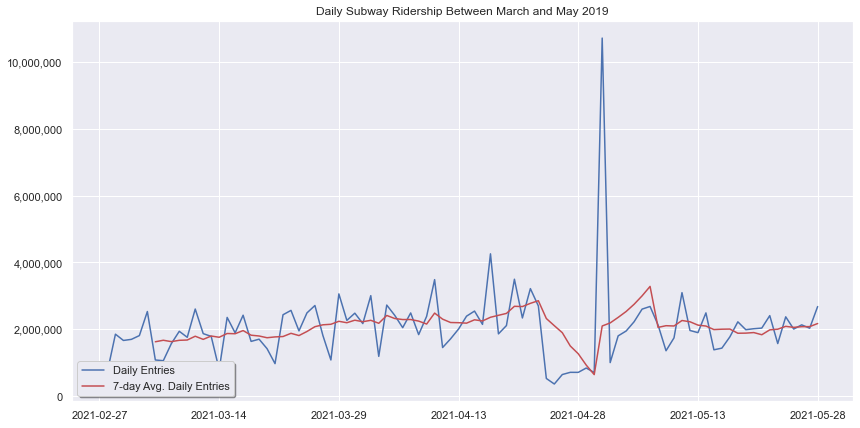

In [21]:
#fig = plt.figure(figsize = [15, 10])
#ax = fig.add_subplot()

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(sum_daily.DATE, sum_daily.DAILY_ENTRIES, label='Daily Entries')
ax.plot(sum_daily.DATE, sum_daily['seven_day_rolling_avg'], c='r', label='7-day Avg. Daily Entries')
ax.set_title('Daily Subway Ridership Between March and May 2019')
ax.legend(shadow = True, loc = 3)
ax.ticklabel_format(axis='y', style='plain')
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

## Import Citi Bike data from SQL DB

In [22]:
con = sqlite3.connect("citi_bike_2021.db")

query = '''
SELECT started_at, start_station_name
from tripdata;
'''

# Load the data into a DataFrame
bike_df = pd.read_sql_query(query, con, parse_dates='started_at')

con.close()

In [23]:
bike_df.head()

,started_at,start_station_name
0,2021-03-22 18:30:56,Willoughby Ave & Wyckoff Ave
1,2021-03-30 11:47:49,Franklin Ave & Myrtle Ave
2,2021-03-04 19:53:50,Adam Clayton Powell Blvd & W 141 St
3,2021-03-20 13:05:54,Bayard St & Baxter St
4,2021-03-20 08:31:09,Bayard St & Baxter St


In [24]:
#bike_daily = bike_df.groupby(bike_df.starttime.dt.isocalendar().week).starttime.count().to_frame()
#bike_df['started_at'] = pd.to_datetime(bike_df.started_at)

bike_daily = bike_df.groupby(bike_df.started_at.dt.date).started_at.count().to_frame()
bike_daily['seven_day_rolling_avg'] = bike_daily.started_at.rolling(7).mean()

In [101]:
bike_daily.tail(30)

,started_at,seven_day_rolling_avg
started_at,,
2021-05-02,93982,83664.857143
2021-05-03,60831,82118.142857
2021-05-04,87014,83180.714286
2021-05-05,49749,76526.428571
2021-05-06,93267,79768.000000
2021-05-07,91204,81269.571429
2021-05-08,59759,76543.714286
2021-05-09,53317,70734.428571
2021-05-10,71172,72211.714286


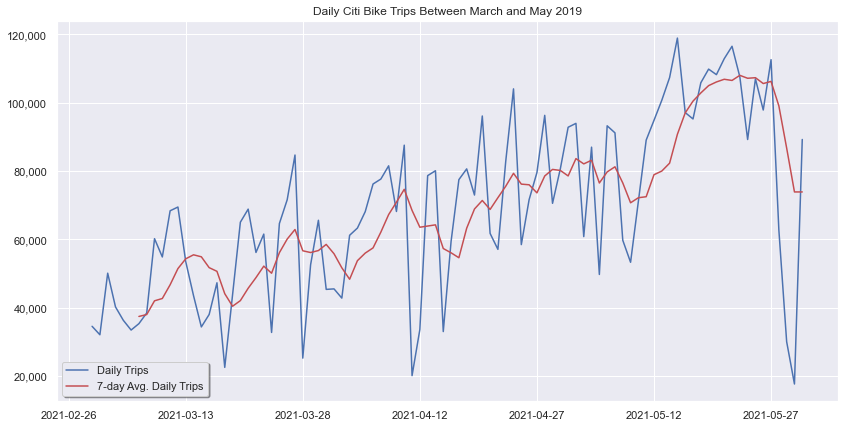

In [26]:
#fig = plt.figure(figsize = [15, 10])
#ax = fig.add_subplot()

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(bike_daily.index, bike_daily.started_at, label='Daily Trips')
ax.plot(bike_daily.index, bike_daily.seven_day_rolling_avg, c='r', label='7-day Avg. Daily Trips')
ax.set_title('Daily Citi Bike Trips Between March and May 2019')
ax.legend(shadow = True, loc = 3)
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));
#ax.set_xlim([dt.date(2020, 3, 1), dt.date(2020, 5, 31)])

# Some Preliminary Plots 

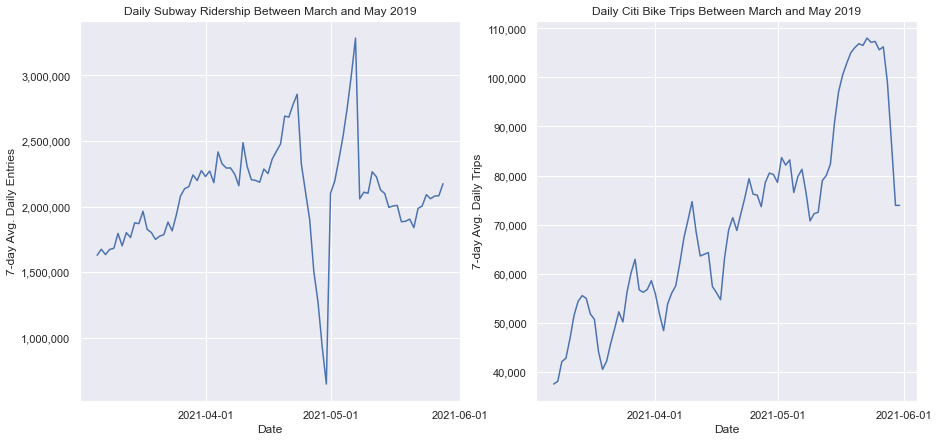

In [27]:
#plt.figure(figsize=[16,7])  

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

ax1.plot(sum_daily.DATE, sum_daily.seven_day_rolling_avg)
ax1.set(xlabel='Date', ylabel="7-day Avg. Daily Entries",
       title="Daily Subway Ridership Between March and May 2019")
ax1.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.grid(True);

ax2.plot(bike_daily.index, bike_daily.seven_day_rolling_avg)
ax2.set(xlabel='Date', ylabel="7-day Avg. Daily Trips",
       title='Daily Citi Bike Trips Between March and May 2019')
ax2.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.grid(True);

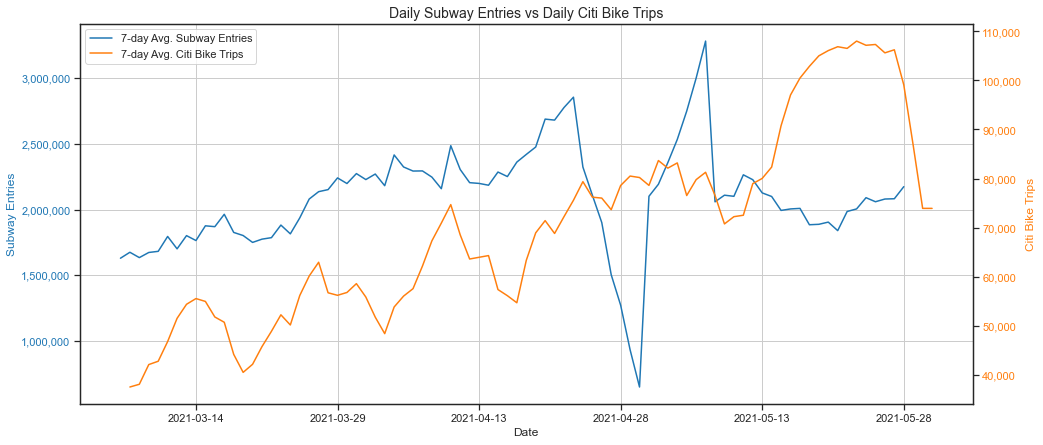

In [128]:
# Set seaborn style to ticks
sns.set_style('ticks')

fig, ax1 = plt.subplots(figsize=(16, 7))

p1, = ax1.plot(sum_daily.DATE, sum_daily.seven_day_rolling_avg,
               c='tab:blue', label='7-day Avg. Subway Entries')
ax1.set_title('Daily Subway Entries vs Daily Citi Bike Trips', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Subway Entries', color='tab:blue')
ax1.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

ax2 = ax1.twinx() 

p2, =ax2.plot(bike_daily.index, bike_daily.seven_day_rolling_avg,
              c='tab:orange', label='7-day Avg. Citi Bike Trips')
ax2.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel("Citi Bike Trips", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
lns = [p1, p2]
ax1.legend(handles=lns, loc=2)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.savefig('result_2021.png')

## Working on the Station Daily 2021 dataframe

In [39]:
station_daily.head()

,STATION,LINENAME,DATE,DAILY_ENTRIES
0,1 AV,L,02/28/2021,3639.0
1,1 AV,L,03/01/2021,6086.0
2,1 AV,L,03/02/2021,6254.0
3,1 AV,L,03/03/2021,6557.0
4,1 AV,L,03/04/2021,6506.0


In [40]:
# Add rolling 7-day average daily entries
station_daily['seven_day_rolling_avg'] = station_daily.groupby('STATION')['DAILY_ENTRIES'].rolling(7).mean().reset_index(0, drop=True)
station_daily.head(10)

,STATION,LINENAME,DATE,DAILY_ENTRIES,seven_day_rolling_avg
0,1 AV,L,02/28/2021,3639.0,NaN
1,1 AV,L,03/01/2021,6086.0,NaN
2,1 AV,L,03/02/2021,6254.0,NaN
3,1 AV,L,03/03/2021,6557.0,NaN
4,1 AV,L,03/04/2021,6506.0,NaN
5,1 AV,L,03/05/2021,6602.0,NaN
6,1 AV,L,03/06/2021,4847.0,5784.428571
7,1 AV,L,03/07/2021,3694.0,5792.285714
8,1 AV,L,03/08/2021,5999.0,5779.857143
9,1 AV,L,03/09/2021,6329.0,5790.571429


In [41]:
station_drop = station_daily[['STATION', 'LINENAME', 'seven_day_rolling_avg']].groupby(['STATION', 'LINENAME']).agg(['max', 'min']).reset_index()
station_drop.columns = ['_'.join(col).rstrip('_') for col in station_drop.columns.values]
station_drop

,STATION,LINENAME,seven_day_rolling_avg_max,seven_day_rolling_avg_min
0,1 AV,L,133006.142857,5744.142857
1,103 ST,1,7528.142857,3104.428571
2,103 ST,6,9671.714286,3966.428571
3,103 ST,BC,4560.857143,1233.571429
4,103 ST-CORONA,7,20328.142857,8890.571429
...,...,...,...,...
473,WOODLAWN,4,5885.142857,2597.000000
474,WORLD TRADE CTR,ACE23,3165.428571,1762.428571
475,WTC-CORTLANDT,1,4020.285714,1530.285714
476,YORK ST,F,5294.857143,1732.428571


In [42]:
# Rename columns: add year
station_drop.rename(columns = {'seven_day_rolling_avg_max':'2021_7_day_max',
                              'seven_day_rolling_avg_min':'2021_7_day_min'}, inplace = True)

In [45]:
# Import data for 2020
import pickle
with open('station_drop.pickle_2020','rb') as read_file:
    station_drop_2020 = pickle.load(read_file)
station_drop_2020.head()

,STATION,LINENAME,seven_day_rolling_avg_max,seven_day_rolling_avg_min,drop_%
388,NEWARK HM HE,1,3842.571429,0.000000,1.000000
446,THIRTY ST,1,42824.000000,3.857143,0.999910
153,81 ST-MUSEUM,BC,184434.000000,314.285714,0.998296
158,86 ST,BC,171378.428571,402.857143,0.997649
243,CENTRAL PK N110,23,7253.571429,21.000000,0.997105


In [46]:
station_drop_2020.rename(columns = {'seven_day_rolling_avg_max':'2020_7_day_max',
                                    'seven_day_rolling_avg_min':'2020_7_day_min'}, inplace = True)

In [50]:
station_drop_2020.drop('drop_%', axis=1, inplace=True)

In [51]:
station_drop_2020.head()

,STATION,LINENAME,2020_7_day_max,2020_7_day_min
388,NEWARK HM HE,1,3842.571429,0.000000
446,THIRTY ST,1,42824.000000,3.857143
153,81 ST-MUSEUM,BC,184434.000000,314.285714
158,86 ST,BC,171378.428571,402.857143
243,CENTRAL PK N110,23,7253.571429,21.000000


In [53]:
# Merge two tables: station_drop (for 2021) and station_drop_2020 (for 2020)
station_chrono = station_drop.merge(station_drop_2020, left_on=['STATION', 'LINENAME'],
                                   right_on=['STATION', 'LINENAME'])

In [54]:
station_chrono.head()

,STATION,LINENAME,2021_7_day_max,2021_7_day_min,2020_7_day_max,2020_7_day_min
0,1 AV,L,133006.142857,5744.142857,112996.428571,1100.857143
1,103 ST,1,7528.142857,3104.428571,10076.000000,818.142857
2,103 ST,6,9671.714286,3966.428571,11380.714286,1736.714286
3,103 ST,BC,4560.857143,1233.571429,3980.857143,353.428571
4,103 ST-CORONA,7,20328.142857,8890.571429,18151.571429,1888.428571


In [55]:
station_chrono['2021vs2020'] = (station_chrono['2021_7_day_max'] - station_chrono['2020_7_day_max'] 
                             ) / station_chrono['2020_7_day_max']
station_chrono

,STATION,LINENAME,2021_7_day_max,2021_7_day_min,2020_7_day_max,2020_7_day_min,2021vs2020
0,1 AV,L,133006.142857,5744.142857,112996.428571,1100.857143,0.177083
1,103 ST,1,7528.142857,3104.428571,10076.000000,818.142857,-0.252864
2,103 ST,6,9671.714286,3966.428571,11380.714286,1736.714286,-0.150166
3,103 ST,BC,4560.857143,1233.571429,3980.857143,353.428571,0.145697
4,103 ST-CORONA,7,20328.142857,8890.571429,18151.571429,1888.428571,0.119911
...,...,...,...,...,...,...,...
473,WOODLAWN,4,5885.142857,2597.000000,5653.857143,838.571429,0.040908
474,WORLD TRADE CTR,ACE23,3165.428571,1762.428571,75691.000000,434.857143,-0.958180
475,WTC-CORTLANDT,1,4020.285714,1530.285714,12937.142857,321.428571,-0.689245
476,YORK ST,F,5294.857143,1732.428571,10862.142857,418.714286,-0.512540


In [133]:
station_chrono.sort_values('2021vs2020', inplace=True, ignore_index=True)
station_chrono.head()

,STATION,LINENAME,2021_7_day_max,2021_7_day_min,2020_7_day_max,2020_7_day_min,2021vs2020
0,LORIMER ST,JM,1790.714286,1367.571429,107894.000000,429.000000,-0.983403
1,238 ST,1,3019.000000,1072.428571,123216.428571,428.428571,-0.975498
2,FRANKLIN AV,ACS,3837.857143,1588.571429,122760.714286,561.857143,-0.968737
3,DEKALB AV,L,5712.428571,3934.714286,152421.142857,825.428571,-0.962522
4,DEKALB AV,BDNQR,6116.000000,4938.428571,146911.285714,1332.142857,-0.958369


In [110]:
sum(station_chrono['2021vs2020'] > 0)

107

In [146]:
station_chrono[station_chrono['2020_7_day_max'] > 70000]
#station_chrono[station_chrono['STATION'].str.contains('42 ST')]

,STATION,LINENAME,2021_7_day_max,2021_7_day_min,2020_7_day_max,2020_7_day_min,2021vs2020
0,LORIMER ST,JM,1790.714286,1367.571429,107894.000000,429.000000,-0.983403
1,238 ST,1,3019.000000,1072.428571,123216.428571,428.428571,-0.975498
2,FRANKLIN AV,ACS,3837.857143,1588.571429,122760.714286,561.857143,-0.968737
3,DEKALB AV,L,5712.428571,3934.714286,152421.142857,825.428571,-0.962522
4,DEKALB AV,BDNQR,6116.000000,4938.428571,146911.285714,1332.142857,-0.958369
5,WORLD TRADE CTR,ACE23,3165.428571,1762.428571,75691.000000,434.857143,-0.958180
6,EUCLID AV,AC,4016.285714,3483.857143,87776.714286,1534.714286,-0.954244
8,CANAL ST,ACE,4432.000000,1355.142857,72102.285714,465.142857,-0.938532
10,86 ST,BC,13040.000000,2291.714286,171378.428571,402.857143,-0.923911
11,WALL ST,23,7079.285714,2849.142857,85896.285714,586.714286,-0.917583


In [138]:
com_area = station_chrono.loc[[5, 11, 23, 26, 115, 122, 265, 297]]
com_area

,STATION,LINENAME,2021_7_day_max,2021_7_day_min,2020_7_day_max,2020_7_day_min,2021vs2020
5,WORLD TRADE CTR,ACE23,3165.428571,1762.428571,75691.000000,434.857143,-0.958180
11,WALL ST,23,7079.285714,2849.142857,85896.285714,586.714286,-0.917583
23,34 ST-PENN STA,123,12035.142857,4824.285714,81639.428571,1014.571429,-0.852582
26,42 ST-PORT AUTH,ACENQRS1237W,24344.428571,3633.142857,121829.714286,4014.571429,-0.800177
115,51 ST,6,6928.285714,2861.142857,15721.285714,583.714286,-0.559305
122,42 ST-BRYANT PK,BDFM7,14763.000000,6291.714286,33193.428571,1257.285714,-0.555243
265,103 ST,1,7528.142857,3104.428571,10076.000000,818.142857,-0.252864
297,96 ST,6,11846.142857,4976.000000,14312.428571,1572.714286,-0.172318


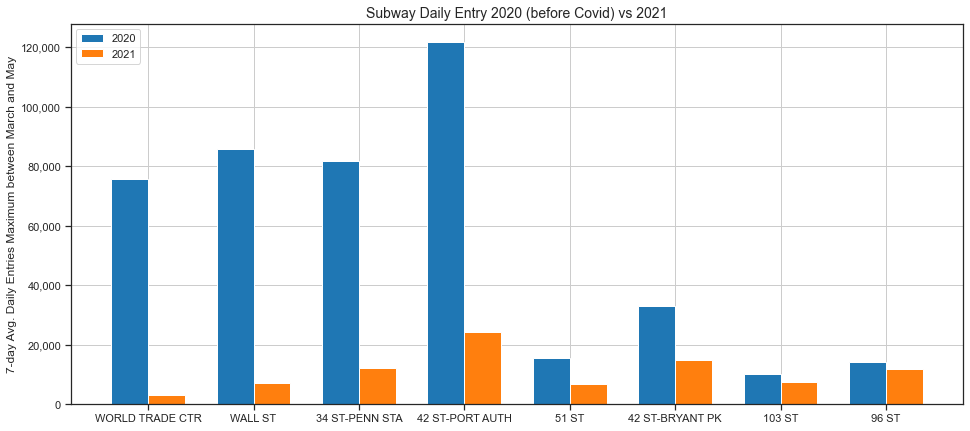

In [145]:
import numpy as np

x = np.arange(len(com_area))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 7))
rects1 = ax.bar(x - width/2, com_area['2020_7_day_max'], width, label='2020', color='tab:blue')
rects2 = ax.bar(x + width/2, com_area['2021_7_day_max'], width, label='2021', color='tab:orange')

ax.set_ylabel('7-day Avg. Daily Entries Maximum between March and May')
ax.set_title('Subway Daily Entry 2020 (before Covid) vs 2021', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(com_area['STATION'])
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid()
ax.legend(loc=2);

plt.savefig('Subway_drop_2020_2021.png')